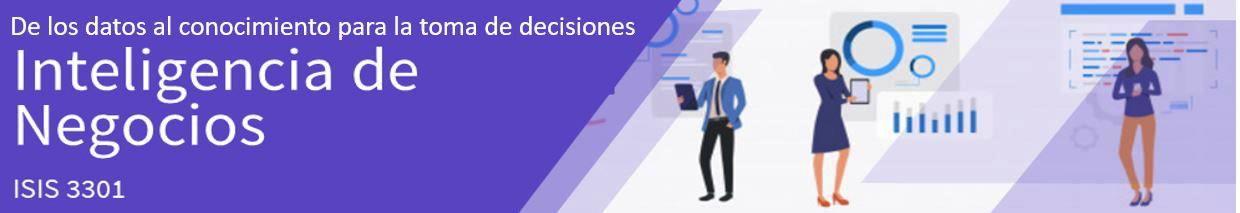

# Procesamiento de Lenguaje Natural (NLP): Análisis (clasificación) de sentimientos

In [1]:
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
# Descargando las stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /home/jj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Función para tokenizar los tweets
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading tweets

In [5]:
tweets_df = pd.read_csv('./data/tweets.csv', sep = ',')

In [6]:
tweets_df.shape

(648, 2)

In [7]:
tweets_df.sample(5)

,full_text,sentiment
313,"La derecha Colombiana + época de elecciones = a terrorismo desatado, el país está hundido en un hoyo tan profundo que no se ve solución a nada. #colombia",negative
164,"#ColombiaDecide | Gustavo Petro contó con gran afluencia en la plaza Alfonso López, en Valledupar. Por más de una hora el candidato del Pacto Histórico expuso sus propuestas y compartió con algunos de sus simpatizantes. Más en https://t.co/0Rr4ts0rOv https://t.co/iKv6rxoH7m",neutral
621,Ya hubo un FRAUDE en las elecciones al congreso que Favoreció al #PactoHistorico \n\nSe Advierte un fraude wn las próximas elecciones del 29 de Mayo.\n\n¿Que esperan los entes de control para intervenir?\n\nSeñores @FiscaliaCol\n@PGN_COL @CNE_COLOMBIA @PoliciaColombia https://t.co/s67ywJIM5W,negative
529,Lo que me queda claro con este video es que los jurados de votación en las elecciones pasadas eran petristas.\nPara las proximas elecciones presidenciales el @CNE_COLOMBIA y la @Registraduria debe garantizarnos que los jurados todos no sean de la izquierda.\n#FicoUneAColombia https://t.co/jPUpwZzQCq,NaN
130,Se acercan las elecciones presidenciales en Colombia y las comparaciones con Venezuela han sido inevitables. ¿Está Colombia como Venezuela? #Análisis por @jgmartinez522\n\nHaz clic en el video para más detalles 👇\n https://t.co/zfKDhPWfAK,neutral


In [8]:
tweets_df['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.433642
NaN         0.364198
neutral     0.169753
positive    0.032407
Name: sentiment, dtype: float64

### Filtrando los tweets que aún no han sido etiquetados

In [9]:
tweets_labeled_df = tweets_df.loc[tweets_df['sentiment'].notnull()]

In [10]:
# Tweets a ser usados para entrenar y evaluar el modelo
tweets_labeled_df.shape

(412, 2)

In [11]:
# Tweets descartados debido a que no se encuentran etiquetados
tweets_df.loc[tweets_df['sentiment'].isnull()].shape

(236, 2)

In [12]:
# Scenario 1: Treating neutral as positive classes
tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})

# Scenario 2: Working only with positive and negative classes
# Removing neutral class
#tweets_labeled_df = tweets_labeled_df.loc[tweets_labeled_df['sentiment'].isin(['positive', 'negative'])]

# Scenario 3: Working with all classes

/tmp/ipykernel_40252/3352082825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})


In [13]:
tweets_labeled_df['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.682039
positive    0.317961
Name: sentiment, dtype: float64

### Diviendo los tweets etiquetados en los conjuntos de entrenamiento y prueba

In [14]:
# El parámetro 'stratify' es útil para asegurar que ambos conjuntos de datos queden aproximadamente balanceados
# Cuando se cuenta con muy pocos datos etiquetados, por lo general se debe disponer de una menor cantidad de datos para evaluación
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)

In [15]:
X_train.shape

(329,)

In [16]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.680851
positive    0.319149
Name: sentiment, dtype: float64

In [17]:
X_test.shape

(83,)

In [18]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.686747
positive    0.313253
Name: sentiment, dtype: float64

### Vectorizando los tweets

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="./imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="./imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [19]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)

In [20]:
X_bow = bow.fit_transform(X_train)

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got {'tuyas', 'habían', 'tenía', 'habéis', 'sean', 'tendrán', 'vosotros', 'seríais', 'estada', 'estuviésemos', 'sentid', 'estaréis', 'otro', 'estaré', 'hubieran', 'durante', 'o', 'hubiese', 'habrás', 'es', 'sea', 'serán', 'han', 'estaba', 'hubieses', 'vuestros', 'habíamos', 'tendrá', 'estuve', 'el', 'donde', 'algo', 'estuvimos', 'fuese', 'seamos', 'otros', 'sus', 'suyos', 'estés', 'estarán', 'mía', 'serías', 'tanto', 'habré', 'tendré', 'habréis', 'estuviese', 'tuvieron', 'muy', 'estarías', 'habidas', 'estados', 'seríamos', 'tendríamos', 'míos', 'nosotras', 'que', 'habrán', 'en', 'nuestras', 'esa', 'tuviese', 'por', 'lo', 'hubiésemos', 'hubimos', 'estarían', 'tuyos', 'estemos', 'todo', 'tengamos', 'he', 'estuvierais', 'estuvieseis', 'sentidas', 'ante', 'fueron', 'tu', 'hubiste', 'esto', 'fue', 'estabais', 'este', 'seas', 'su', 'esta', 'suyo', 'se', 'más', 'antes', 'tenido', 'qué', 'tuvieras', 'poco', 'tengas', 'estas', 'tuviste', 'tendremos', 'ti', 'yo', 'estará', 'del', 'éramos', 'tuvierais', 'hayáis', 'esas', 'hube', 'hayas', 'cual', 'habría', 'fuéramos', 'nuestra', 'hubisteis', 'tendrás', 'al', 'mi', 'les', 'mí', 'fuiste', 'sentido', 'suyas', 'somos', 'sin', 'a', 'vuestro', 'ha', 'tenías', 'tiene', 'tendrías', 'ya', 'habíais', 'vuestra', 'fuésemos', 'vuestras', 'tendréis', 'habidos', 'sentida', 'estaban', 'hubierais', 'me', 'fueseis', 'sintiendo', 'hemos', 'porque', 'algunos', 'estadas', 'ni', 'seréis', 'esté', 'tuviesen', 'está', 'eso', 'tenga', 'soy', 'estaría', 'habido', 'pero', 'estuviesen', 'tuvieseis', 'estuvieran', 'tuya', 'hayamos', 'para', 'cuando', 'teníamos', 'estos', 'estad', 'tenidas', 'siente', 'ellos', 'nada', 'tengáis', 'algunas', 'fuera', 'con', 'fuimos', 'eran', 'habida', 'hubiesen', 'tendrían', 'desde', 'serían', 'estuvo', 'hayan', 'mío', 'serás', 'tendría', 'habiendo', 'y', 'estuviste', 'estaremos', 'quien', 'estuvieras', 'teniendo', 'seré', 'habremos', 'ella', 'hubieras', 'estando', 'estaríamos', 'otras', 'habrías', 'todos', 'tenemos', 'le', 'tuviésemos', 'habrá', 'eres', 'estuviéramos', 'había', 'tuvimos', 'tuviera', 'estáis', 'están', 'haya', 'hubieseis', 'como', 'te', 'estamos', 'tuvieses', 'ellas', 'nuestros', 'habías', 'estado', 'estábamos', 'tuyo', 'no', 'estaríais', 'mis', 'un', 'vosotras', 'estuvisteis', 'sería', 'tienes', 'sí', 'tú', 'estás', 'estoy', 'tus', 'estuviera', 'e', 'estuvieses', 'has', 'otra', 'contra', 'estén', 'era', 'fueras', 'seremos', 'teníais', 'hay', 'tened', 'habríais', 'estuvieron', 'nuestro', 'será', 'seáis', 'tuvo', 'tuvieran', 'tenida', 'sentidos', 'estéis', 'estarás', 'sobre', 'fueses', 'las', 'hubo', 'tuve', 'fueran', 'fuesen', 'estabas', 'estar', 'tenéis', 'hubiéramos', 'entre', 'tuviéramos', 'habrían', 'hasta', 'suya', 'os', 'tenidos', 'de', 'fuerais', 'sois', 'son', 'tienen', 'esos', 'tengan', 'mucho', 'nosotros', 'quienes', 'uno', 'tengo', 'la', 'una', 'eras', 'hubiera', 'habríamos', 'muchos', 'ese', 'tendríais', 'también', 'él', 'tenían', 'nos', 'hubieron', 'los', 'mías', 'unos', 'fui', 'erais', 'fuisteis', 'tuvisteis'} instead.

In [ ]:
len(bow.vocabulary_)

2591

In [ ]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)

In [ ]:
X_tfidf = tfidf.fit_transform(X_train)

In [ ]:
len(tfidf.vocabulary_)

2591

### Entrenando y evaluando un modelo usado BoW

In [ ]:
bow_model = RandomForestClassifier(random_state = 2)

In [ ]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<AxesSubplot:>

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128588 (\N{PERSON RAISING BOTH HANDS IN CELEBRATION}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128171 (\N{DIZZY SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


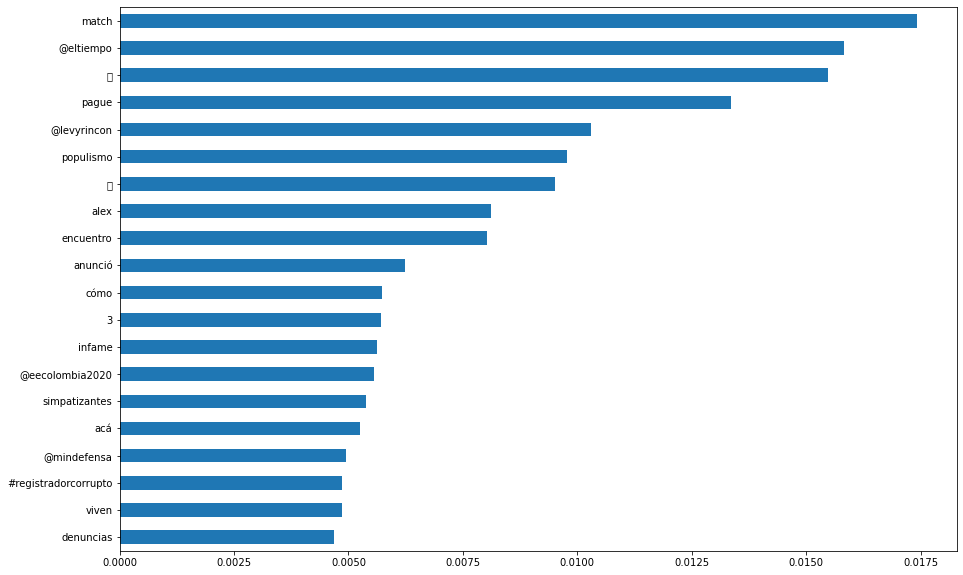

In [ ]:
# La 'feature importance' en modelos basados en árboles de decisión indican cuales son las características más importantes al momento de tomar una decisión
pd.Series(bow_model.feature_importances_, index = bow.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [ ]:
bow_estimators = bow_model.estimators_
print('Number of trees:', len(bow_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 62.18


In [ ]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

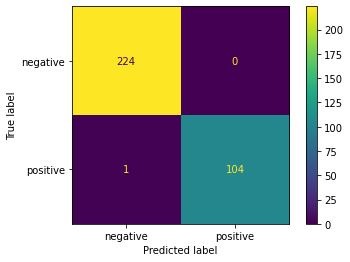

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

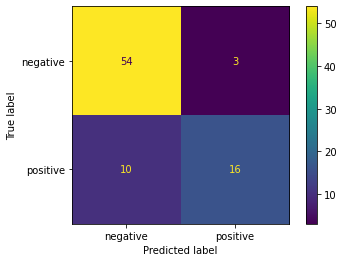

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [ ]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_bow_predict, pos_label = 'positive'))
    print('Recall:', recall_score(y_train, y_train_bow_predict, pos_label = 'positive'))
    print('F1:', f1_score(y_train, y_train_bow_predict, pos_label = 'positive'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_bow_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_bow_predict, average = None))
    print('F1:', f1_score(y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 0.9904761904761905
F1: 0.9952153110047847


In [ ]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 'positive'))
    print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 'positive'))
    print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 'positive'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
    print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: 0.8421052631578947
Recall: 0.6153846153846154
F1: 0.7111111111111111


### Entrenando y evaluando un modelo usado TF-IDF

In [ ]:
tfidf_model = RandomForestClassifier(random_state = 3)

In [ ]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<AxesSubplot:>

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128171 (\N{DIZZY SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128588 (\N{PERSON RAISING BOTH HANDS IN CELEBRATION}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


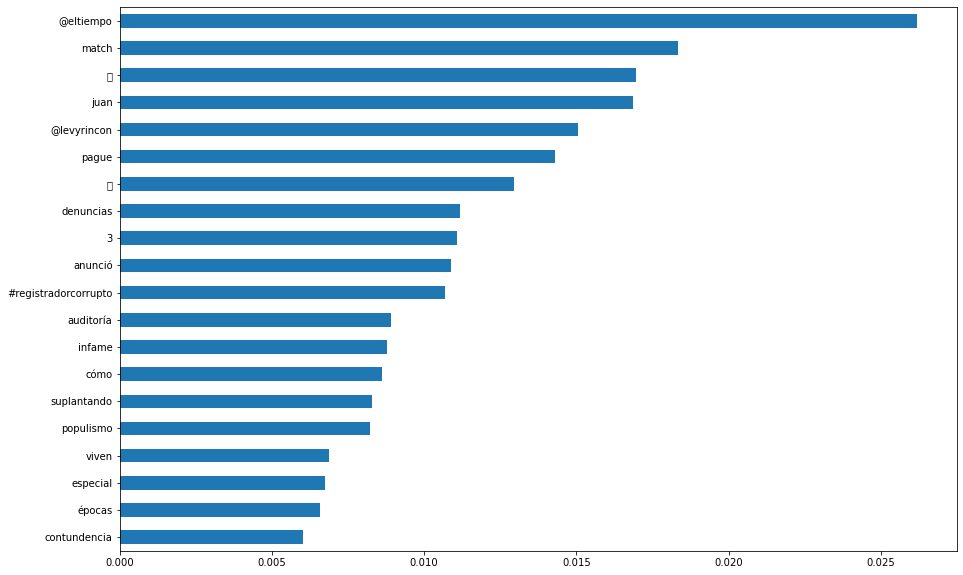

In [ ]:
pd.Series(tfidf_model.feature_importances_, index = tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [ ]:
tfidf_estimators = tfidf_model.estimators_
print('Number of trees:', len(tfidf_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 49.66


In [ ]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

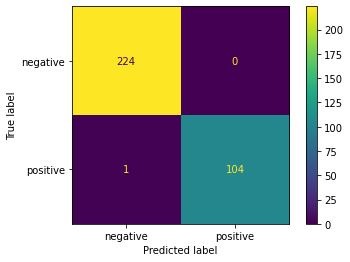

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

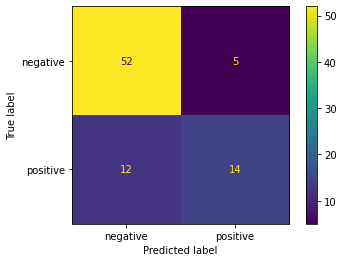

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [ ]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, pos_label = 'positive'))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, pos_label = 'positive'))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, pos_label = 'positive'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, average = None))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, average = None))

Precision: 1.0
Recall: 0.9904761904761905
F1: 0.9952153110047847


In [ ]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: 0.7368421052631579
Recall: 0.5384615384615384
F1: 0.6222222222222222


### Análisis del error

In [ ]:
error_df = pd.concat([
    pd.concat([X_test, y_test], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict)
], axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [ ]:
error_df.loc[error_df['actual'] != error_df['predicted']].shape

(17, 3)

In [ ]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

,full_text,actual,predicted
12,El candidato presidencial Rodolfo Hernández se refirió en Sigue La W sobre las alianzas políticas de cara a las elecciones.\nhttps://t.co/DuBfISBrHx,positive,negative
38,"#OtraPregunta \n""Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia""...\nEsto no pinta nada bien... y si además gana Lula en Brasil...\n¿Esto como que va para largo? https://t.co/wpQsl5KoRe",negative,positive
14,"#DiloConIndignación: ¿Para qué sirve el control previo y concomitante de la @CGR_Colombia? Estamos a 20 días de las elecciones y ya todos los contratos y dinero fueron entregados. ¿Qué va a pasar con esos recursos? Como ciudadanos tenemos que despertar, se ríen en nuestra cara. https://t.co/p2CP7sI0Sj",negative,positive
55,"En la Video Columna de La Conversa, este sábado 8:00 p.m., análisis sobre la actualidad política y social de Colombia, a escasos días de elecciones presidenciales. https://t.co/DcJRYFli9t",positive,negative
5,Me late que en estas elecciones las mujeres de Colombia somos las que vamos a poner Presidente 😍😍😍 #FicoPresidenteEnPrimeraVuelta https://t.co/Kb5EIULNlJ,positive,negative
71,"""Lo que está viviendo Latinoamérica, cortesías de los procesos del Foro de Sao Paulo, se va poniendo realmente delicado. Hay que estar pendiente de lo que sucede en Chile y Perú, previo a las elecciones de Colombia."" @Noelleal",negative,positive
65,"✊🏽Apertura y estabilidad democrática en Colombia, 🗳 el análisis de Daniel Ricardo Amaya en revista #CienDías edición N. 104 📲 https://t.co/d2YUoyQ8k6\n\n📸 @PactoHistorico https://t.co/c1UQd4KNDJ",positive,negative
1,#NarcotraFICO se tomó a Colombia para impedir las elecciones 2022/2026\n\nhttps://t.co/oa14iGRkwJ https://t.co/1bUQEGwhWh,negative,positive
75,"@lauraro Yo vote por el NO y hoy siento que nos podría pasar lo mismo con las próximas elecciones si no actuamos unidos!!\nDejemos el odio irracional, aquí se trata es de salvar el presente y futuro de Colombia!\nQuien más se une??",positive,negative
60,"Además, los gráficos y mapas electorales demuestran la importancia electoral que tiene el centro del país, ante la densidad poblacional y la tradición de salir a votar. https://t.co/tVxPTMLkC2",positive,negative


### Model selection

In [ ]:
pipeline = Pipeline(steps = [
    ('vectorizer', CountVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)),
    ('classifier', RandomForestClassifier(random_state = 4))
])

In [ ]:
param_grid = {
    'vectorizer': [CountVectorizer(tokenizer = tokenizer, stop_words = stop_words), TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)],
    'vectorizer__lowercase': [True, False],
    'classifier__n_estimators': [50, 100, 150, 200, 250, 300],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [20, 40, 60, 80]
}

In [ ]:
search = GridSearchCV(pipeline, param_grid, scoring = ['precision', 'recall', 'f1'], refit = 'f1', cv = 10, return_train_score = True, verbose = 1)

In [ ]:
search.fit(X_train, y_train.replace({'negative': 0, 'positive': 1}))

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words={'a', 'al',
                                                                    'algo',
                                                                    'algunas',
                                                                    'algunos',
                                                                    'ante',
                                                                    'antes',
                                                                    'como',
                                                                    'con',
                                                                    'contra',
                                                                    'cual',
                                                                    'cuando',
                                                                    'de', 'de

In [ ]:
search.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 60,
 'classifier__n_estimators': 50,
 'vectorizer': TfidfVectorizer(lowercase=False,
                 stop_words={'a', 'al', 'algo', 'algunas', 'algunos', 'ante',
                             'antes', 'como', 'con', 'contra', 'cual', 'cuando',
                             'de', 'del', 'desde', 'donde', 'durante', 'e', 'el',
                             'ella', 'ellas', 'ellos', 'en', 'entre', 'era',
                             'erais', 'eran', 'eras', 'eres', 'es', ...},
                 tokenizer=<function tokenizer at 0x7f87f803faf0>),
 'vectorizer__lowercase': False}

In [ ]:
search.best_score_

0.5602474323062558

In [ ]:
y_test_search_predict = search.best_estimator_.predict(X_test)

In [ ]:
print('Precision:', precision_score(y_test.replace({'negative': 0, 'positive': 1}), y_test_search_predict))
print('Recall:', recall_score(y_test.replace({'negative': 0, 'positive': 1}), y_test_search_predict))
print('F1:', f1_score(y_test.replace({'negative': 0, 'positive': 1}), y_test_search_predict))

Precision: 0.7777777777777778
Recall: 0.5384615384615384
F1: 0.6363636363636364
